# Prediksi Harga Beras Harian di Jakarta Menggunakan Metode *Long Short-Term Memory* (LSTM)

#Import Datasets dan Melakukan Preprocessing

### Import library
Pandas & NumPy → mengelola data time series

MinMaxScaler → normalisasi data

LSTM & Dense → membangun arsitektur deep learning

Matplotlib → visualisasi hasil training & prediksi

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Datasets yang akan digunakan
Dataset *Jakarta Commodity by Cities* didapat dari : https://www.kaggle.com/datasets/devbytoo/jakarta-commodity-cities

Datasets tersebut dapat digunakan untuk metode LSTM karena memiliki karakteristik data runtut waktu dan pola musiman pada harga komoditas. Namun, dataset perlu melalui tahap preprocessing seperti pemilihan satu komoditas dan satu wilayah, penyesuaian format waktu, penanganan missing value dan outlier, serta penentuan periode musiman sebelum dilakukan pemodelan


### Import Datasets


In [96]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/datasets/jakarta-comodities/cities_2024.csv'
dataset2_path = '/content/drive/MyDrive/datasets/jakarta-comodities/cities_2025.csv'

df = pd.read_csv(f'{dataset_path}')
df2 = pd.read_csv(f'{dataset2_path}')
print('Dataset loaded successfully!')

print("\nBerikut adalah 5 baris pertama dari dataset 2024:")
display(df.tail())
print("\nBerikut adalah 5 baris pertama dari dataset 2025:")
display(df2.tail())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully!

Berikut adalah 5 baris pertama dari dataset 2024:


,value,time,commodity_id,commodity_name,avg_value,max_value,min_value,city_id,city_name,Year,Month
65846,10083,2024-12-27,37,Margarin Blueband Sachet,10721,28357,9417,1,Jakarta Barat,2024,12
65847,9917,2024-12-28,37,Margarin Blueband Sachet,10721,28357,9417,1,Jakarta Barat,2024,12
65848,9500,2024-12-29,37,Margarin Blueband Sachet,10721,28357,9417,1,Jakarta Barat,2024,12
65849,9700,2024-12-30,37,Margarin Blueband Sachet,10721,28357,9417,1,Jakarta Barat,2024,12
65850,10083,2024-12-31,37,Margarin Blueband Sachet,10721,28357,9417,1,Jakarta Barat,2024,12



Berikut adalah 5 baris pertama dari dataset 2025:


,daily_price,date,commodity_id,commodity_name,avg_value,max_value,min_value,city_id,city_name,Year,Month
65796,37500,2025-12-04,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
65797,37500,2025-12-05,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
65798,37500,2025-12-06,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
65799,40000,2025-12-07,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
65800,37500,2025-12-08,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12


### Menggabungkan Dua Dataset

kita akan menggabungkan `df` dan `df2` menjadi satu DataFrame baru (`df_combined`).

karena nama kolom daily_price dengan value dan time dengan date tidak sama maka perlu disamakan terlebih dahulu, kemudian baru bisa digabungkan

In [97]:
df2 = df2.rename(columns={'daily_price': 'value', 'date': 'time'})

df_combined = pd.concat([df, df2], ignore_index=True)

print("Dataset berhasil digabungkan. Berikut adalah 5 baris pertama dari df_combined:")
display(df_combined.head())

print("\nBerikut adalah 5 baris terakhir dari df_combined:")
display(df_combined.tail())

print("\nInformasi DataFrame gabungan:")
df_combined.info()


Dataset berhasil digabungkan. Berikut adalah 5 baris pertama dari df_combined:


,value,time,commodity_id,commodity_name,avg_value,max_value,min_value,city_id,city_name,Year,Month
0,14200,2024-01-01,1,Beras IR. I (IR 64),14141,14500,11220,5,Jakarta Utara,2024,1
1,14500,2024-01-02,1,Beras IR. I (IR 64),14141,14500,11220,5,Jakarta Utara,2024,1
2,14333,2024-01-03,1,Beras IR. I (IR 64),14141,14500,11220,5,Jakarta Utara,2024,1
3,14200,2024-01-04,1,Beras IR. I (IR 64),14141,14500,11220,5,Jakarta Utara,2024,1
4,13667,2024-01-05,1,Beras IR. I (IR 64),14141,14500,11220,5,Jakarta Utara,2024,1



Berikut adalah 5 baris terakhir dari df_combined:


,value,time,commodity_id,commodity_name,avg_value,max_value,min_value,city_id,city_name,Year,Month
131647,37500,2025-12-04,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
131648,37500,2025-12-05,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
131649,37500,2025-12-06,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
131650,40000,2025-12-07,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12
131651,37500,2025-12-08,120,Ikan Kembung,37813,40000,37500,1,Jakarta Barat,2025,12



Informasi DataFrame gabungan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131652 entries, 0 to 131651
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   value           131652 non-null  int64 
 1   time            131652 non-null  object
 2   commodity_id    131652 non-null  int64 
 3   commodity_name  131652 non-null  object
 4   avg_value       131652 non-null  int64 
 5   max_value       131652 non-null  int64 
 6   min_value       131652 non-null  int64 
 7   city_id         131652 non-null  int64 
 8   city_name       131652 non-null  object
 9   Year            131652 non-null  int64 
 10  Month           131652 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 11.0+ MB


## Preprocessing
Tahap preprocessing dilakukan dengan menyeleksi data berdasarkan kota Jakarta Pusat dan komoditas Beras Medium.

- Data harian diagregasi menjadi data mingguan menggunakan nilai rata-rata.

- Nilai kosong yang muncul akibat agregasi ditangani menggunakan interpolasi linear, sedangkan outlier dideteksi menggunakan metode IQR dan digantikan dengan nilai median. Hasil preprocessing berupa data runtut waktu bulanan yang  siap digunakan dalam metode smoothing.

### filter datasets

In [98]:
# Seleksi kota & komoditas
df_filtered = df_combined[
    (df_combined['city_name'] == 'Jakarta Pusat') &
    (df_combined['commodity_name'].str.contains('beras', case=False, na=False))
].copy()

# Konversi tanggal
df_filtered['time'] = pd.to_datetime(df_filtered['time'])

# Urutkan data
df_filtered = df_filtered.sort_values('time')

ubah nama kolom menjadi date dan price

In [99]:
df_filtered = df_filtered.rename(columns={'value': 'price', 'time': 'date'})

### Agregasi Data

In [100]:
df_process = (
    df_filtered
    .set_index('date')
    .resample('D')['price']
    .mean()
    .reset_index()
)

### Interpolasi missing value

In [101]:
df_process['price'] = df_process['price'].interpolate(method='linear')

### Ganti outlier dengan median

In [102]:
# Deteksi outlier (IQR)
Q1 = df_process['price'].quantile(0.25)
Q3 = df_process['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_price = df_process['price'].median()

# Ganti outlier dengan median
df_process['price'] = np.where(
    (df_process['price'] < lower_bound) |
    (df_process['price'] > upper_bound),
    median_price,
    df_process['price']
)

## Visualisasi Data
sebelum membuat model kita akan melihat dulu data kita sebelum dan sesudah preprocessing

### Data SEBELUM Preprocessing

In [103]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4192 entries, 3409 to 131284
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price           4192 non-null   int64         
 1   date            4192 non-null   datetime64[ns]
 2   commodity_id    4192 non-null   int64         
 3   commodity_name  4192 non-null   object        
 4   avg_value       4192 non-null   int64         
 5   max_value       4192 non-null   int64         
 6   min_value       4192 non-null   int64         
 7   city_id         4192 non-null   int64         
 8   city_name       4192 non-null   object        
 9   Year            4192 non-null   int64         
 10  Month           4192 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 393.0+ KB


In [104]:
df_filtered.tail()

,price,date,commodity_id,commodity_name,avg_value,max_value,min_value,city_id,city_name,Year,Month
131024,13500,2025-12-08,3,Beras IR. III (IR 64),13490,14750,12000,2,Jakarta Pusat,2025,12
131016,14875,2025-12-08,2,Beras IR. II (IR 64) Ramos,14755,15750,14000,2,Jakarta Pusat,2025,12
131043,19000,2025-12-08,6,Beras Setra I/Premium,17750,19000,16500,2,Jakarta Pusat,2025,12
131035,17000,2025-12-08,5,Beras IR 42/Pera,16896,18000,15667,2,Jakarta Pusat,2025,12
131284,12500,2025-12-08,114,Beras Medium,12500,12500,12500,2,Jakarta Pusat,2025,12


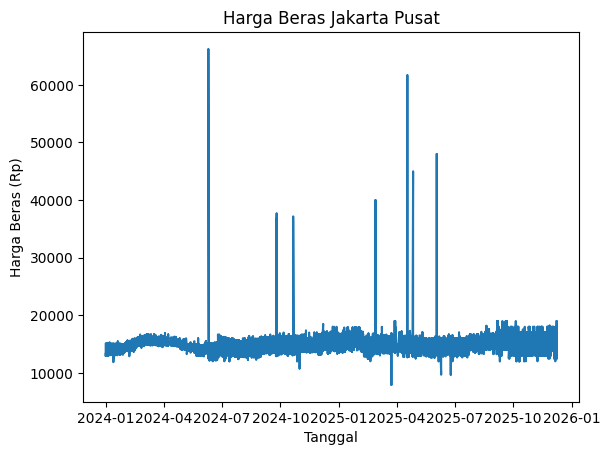

In [105]:
plt.figure()
plt.plot(df_filtered['date'], df_filtered['price'])
plt.xlabel("Tanggal")
plt.ylabel("Harga Beras (Rp)")
plt.title("Harga Beras Jakarta Pusat")
plt.show()

### Data SETELAH Preprocessing

In [106]:
df_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    708 non-null    datetime64[ns]
 1   price   708 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB


In [107]:
df_process.tail()

,date,price
703,2025-12-04,14809.571429
704,2025-12-05,14928.571429
705,2025-12-06,15200.000000
706,2025-12-07,15400.000000
707,2025-12-08,15357.142857


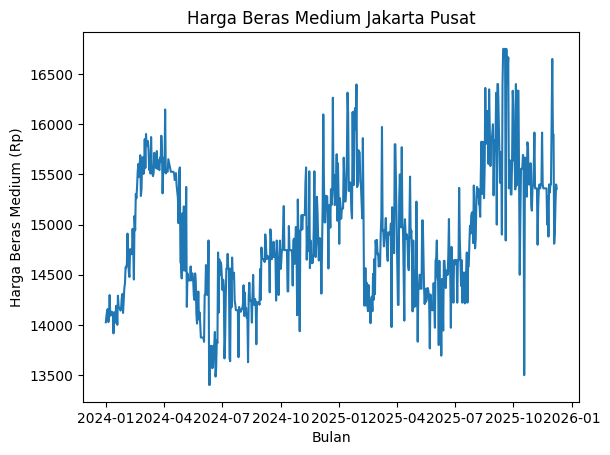

In [108]:
plt.figure()
plt.plot(df_process['date'], df_process['price'])
plt.xlabel("Bulan")
plt.ylabel("Harga Beras Medium (Rp)")
plt.title("Harga Beras Medium Jakarta Pusat")
plt.show()

## Export data


In [109]:
# Ekstrak direktori dari dataset_path
import os
output_path = "/content/drive/MyDrive/datasets/jakarta-comodities/"
save_directory = os.path.dirname(output_path)

csv_output_path = os.path.join(save_directory, 'cleaned_comodities_day.csv')
xlsx_output_path = os.path.join(save_directory, 'cleaned_comodities_day.xlsx')

# Ekspor ke CSV
df_process.to_csv(csv_output_path, index=False)
print(f"Data berhasil diekspor ke: {csv_output_path}")

# Ekspor ke XLSX
df_process.to_excel(xlsx_output_path, index=False)
print(f"Data berhasil diekspor ke: {xlsx_output_path}")

Data berhasil diekspor ke: /content/drive/MyDrive/datasets/jakarta-comodities/cleaned_comodities_day.csv
Data berhasil diekspor ke: /content/drive/MyDrive/datasets/jakarta-comodities/cleaned_comodities_day.xlsx


#Penerapan Metode LSTM pada data yang telah dilakukan preprocesing


### Load Data Hasil Preprocessing

In [110]:
df = pd.read_csv('/content/drive/MyDrive/datasets/jakarta-comodities/cleaned_comodities_day.csv')

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.reset_index(drop=True)

df.tail()

,date,price
703,2025-12-04,14809.571429
704,2025-12-05,14928.571429
705,2025-12-06,15200.000000
706,2025-12-07,15400.000000
707,2025-12-08,15357.142857


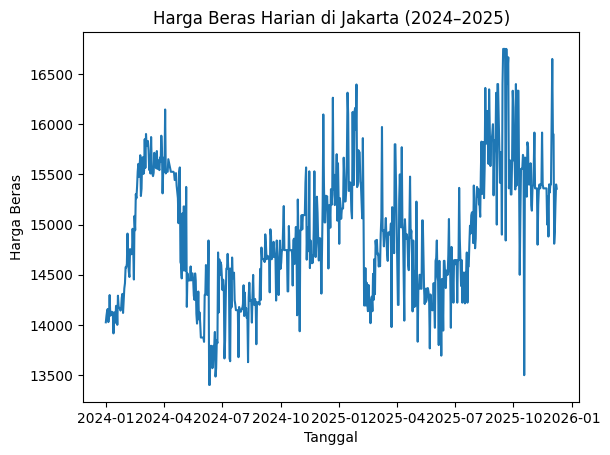

In [111]:
plt.figure()
plt.plot(df['date'], df['price'])
plt.xlabel('Tanggal')
plt.ylabel('Harga Beras')
plt.title('Harga Beras Harian di Jakarta (2024–2025)')
plt.show()

### Normalisasi Data
LSTM sensitif terhadap skala data, sehingga HARUS dinormalisasi.


In [112]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df[['price']])

### Membentuk Data Time Series
Tujuan tahap ini adalah Mengubah data biasa menjadi format yang dipahami LSTM. Karena LSTM tidak membaca satu data, tapi urutan data

Input: harga 7 hari sebelumnya

Output: harga hari ke-8

In [113]:
def create_dataset(data, window_size=7):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 7
X, y = create_dataset(scaled_price, window_size)

### Split Data Train & Validation
80% data → training

20% data → validation

In [114]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

### Menyesuaikan Bentuk Data untuk LSTM
Tujuannya menyesuaikan format:

(samples, timesteps, features)

untuk :

timesteps = 7 hari

features = 1 (harga)

In [115]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

### Membangun Arsitektur Model LSTM
Tujuan tahap ini adalah membuat model deep learning yang sederhana tapi valid.

LSTM 50 unit → menangkap pola jangka pendek & menengah

Dense 1 neuron → output harga

Adam optimizer → cepat & stabil

MSE loss → prediksi numerik

In [116]:
model = Sequential()
model.add(LSTM(
    50, input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Training Model
Model LSTM dilatih hingga 100 epoch dengan menerapkan Early Stopping untuk mencegah overfitting. Training akan dihentikan secara otomatis apabila validation loss tidak mengalami perbaikan selama 5 epoch berturut-turut

In [117]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0843 - val_loss: 0.0228
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0172 - val_loss: 0.0310
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0121 - val_loss: 0.0212
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099 - val_loss: 0.0222
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - val_loss: 0.0221
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100 - val_loss: 0.0207
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093 - val_loss: 0.0207
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - val_loss: 0.0208
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0218
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - val_loss: 0.0208
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - val_loss: 0.0204
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

### Visualisasi Loss Training dan Validation
Grafik loss training dan validation digunakan untuk mengevaluasi proses pembelajaran model. Penurunan nilai loss menunjukkan bahwa model berhasil mempelajari pola data dengan baik. Selain itu, perbandingan antara loss training dan validation membantu dalam mengidentifikasi apakah model mengalami overfitting atau underfitting.

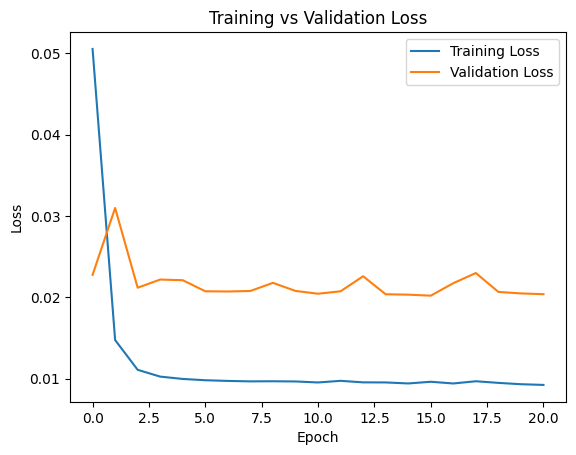

In [118]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

### Prediksi dan Inverse Scaling
Setelah model selesai dilatih, dilakukan proses prediksi menggunakan data validation. Hasil prediksi yang masih dalam bentuk data ternormalisasi kemudian dikembalikan ke skala harga asli menggunakan inverse transform. Langkah ini bertujuan agar hasil prediksi dapat diinterpretasikan secara nyata dalam satuan harga beras.

In [119]:
y_pred = model.predict(X_val)

y_pred_actual = scaler.inverse_transform(y_pred)
y_val_actual  = scaler.inverse_transform(y_val.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


### Visualisasi Perbandingan Harga Aktual dan Prediksi
Visualisasi perbandingan antara harga aktual dan harga hasil prediksi menunjukkan sejauh mana model LSTM mampu mengikuti pola pergerakan harga beras.

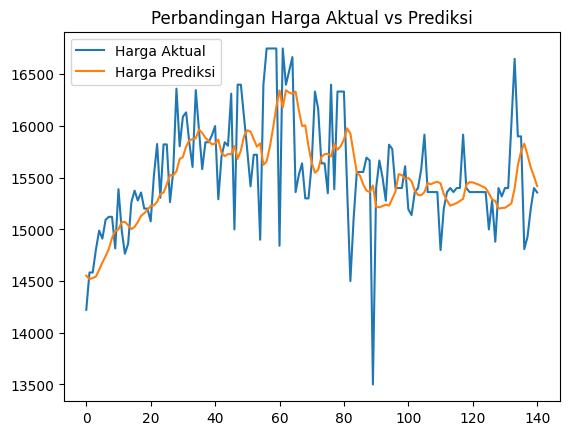

In [120]:
plt.figure()
plt.plot(y_val_actual, label='Harga Aktual')
plt.plot(y_pred_actual, label='Harga Prediksi')
plt.legend()
plt.title('Perbandingan Harga Aktual vs Prediksi')
plt.show()

### Evaluasi Model
Untuk mengukur tingkat kesalahan prediksi secara kuantitatif, digunakan metrik Mean Squared Error (MSE) dan Mean Absolute Error (MAE). MAE menunjukkan rata-rata selisih antara nilai prediksi dan nilai aktual, sedangkan MSE memberikan penalti lebih besar pada kesalahan prediksi yang besar. Nilai metrik ini digunakan sebagai dasar analisis performa model.

In [121]:
mse = mean_squared_error(y_val_actual, y_pred_actual)
mae = mean_absolute_error(y_val_actual, y_pred_actual)

print("MSE:", mse)
print("MAE:", mae)

mape = np.mean(np.abs((y_val_actual - y_pred_actual) / y_val_actual)) * 100
print("MAPE:", mape, "%")


MSE: 226244.65815117175
MAE: 343.2027864187562
MAPE: 2.209606611100075 %
